<a href="https://colab.research.google.com/github/Viorel22/tema1_ia/blob/main/tema1_ia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, average_precision_score,
                             precision_recall_curve)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ---------- 1) Load
path = "/content/drive/MyDrive/earthquake_alert_balanced_dataset.csv"  # pune aici calea corectă dacă e în alt loc
df = pd.read_csv(path)
print("Loaded dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

Loaded dataset shape: (1300, 6)
Columns: ['magnitude', 'depth', 'cdi', 'mmi', 'sig', 'alert']


In [ ]:
target_col = 'alert'
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found in dataset.")

# Drop any rows missing the target
df = df.dropna(subset=[target_col])

# Features
X = df.drop(columns=[target_col])
y = df[target_col]

# If X contains object columns, do simple encoding:
obj_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
if obj_cols:
    print("Object columns detected:", obj_cols)
    for c in obj_cols:
        # try numeric conversion else one-hot for small cardinalities else label-encode
        try:
            X[c] = pd.to_numeric(X[c])
        except Exception:
            if X[c].nunique() <= 30:
                X = pd.get_dummies(X, columns=[c], prefix=c)
            else:
                X[c] = LabelEncoder().fit_transform(X[c].astype(str))

# Fill remaining NA in features with median
X = X.fillna(X.median())

# Encode target labels
le = LabelEncoder()
y_enc = le.fit_transform(y.astype(str))
classes = le.classes_
n_classes = len(classes)
print("Encoded classes:", list(zip(range(n_classes), classes)))

Encoded classes: [(0, 'green'), (1, 'orange'), (2, 'red'), (3, 'yellow')]


In [ ]:
n_total = len(df)
n_train = int(0.8 * n_total)
X_train = X.iloc[:n_train].values
X_test = X.iloc[n_train:].values
y_train = y_enc[:n_train]
y_test = y_enc[n_train:]
print(f"Chronological split: train={n_train}, test={n_total - n_train}")

# ---------- 4) Standardize features (fit on train only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Helper: train, predict, evaluate and measure times
def eval_model(clf, Xtr, ytr, Xte, yte):
    t0 = time.time()
    clf.fit(Xtr, ytr)
    train_time = time.time() - t0
    t1 = time.time()
    ypred = clf.predict(Xte)
    pred_time = time.time() - t1
    acc = accuracy_score(yte, ypred)
    prec = precision_score(yte, ypred, average='macro', zero_division=0)
    rec = recall_score(yte, ypred, average='macro', zero_division=0)
    f1 = f1_score(yte, ypred, average='macro', zero_division=0)
    return {"clf": clf, "y_pred": ypred,
            "train_time_s": train_time, "pred_time_s": pred_time,
            "accuracy": acc, "precision_macro": prec, "recall_macro": rec, "f1_macro": f1}


Chronological split: train=1040, test=260


In [ ]:
k_standard = 113
clf_standard = KNeighborsClassifier(n_neighbors=k_standard, weights='uniform', n_jobs=-1)
res_standard = eval_model(clf_standard, X_train_scaled, y_train, X_test_scaled, y_test)
print("Standard k-NN done.")

# ---------- 6) Model 2: optimized (TimeSeriesSplit + distance)
# Grid search for k (odd values). Set range according to dataset size; here: 1..51 step 2
k_candidates = list(range(1, 52, 2))  # modifică după nevoie; începe mic dacă datele sunt puține
param_grid = {'n_neighbors': k_candidates}
tscv = TimeSeriesSplit(n_splits=3)
knn_distance = KNeighborsClassifier(weights='distance', n_jobs=-1)
grid = GridSearchCV(knn_distance, param_grid, cv=tscv, scoring='accuracy', n_jobs=-1, verbose=1)
t_grid_start = time.time()
grid.fit(X_train_scaled, y_train)   # rulează doar pe train (TimeSeriesSplit respectă ordinea)
t_grid = time.time() - t_grid_start
best_k = grid.best_params_['n_neighbors']
print(f"GridSearch best k = {best_k}, CV accuracy = {grid.best_score_:.4f}, grid_time_s = {t_grid:.1f}")

best_knn = grid.best_estimator_
res_opt = eval_model(best_knn, X_train_scaled, y_train, X_test_scaled, y_test)
res_opt['grid_search_time_s'] = t_grid
res_opt['best_k'] = best_k

Standard k-NN done.
Fitting 3 folds for each of 26 candidates, totalling 78 fits
GridSearch best k = 1, CV accuracy = 0.7410, grid_time_s = 8.2



Results summary:
                                         Method    k   weights  accuracy  \
0                                k-NN standard  113   uniform  0.000000   
1  k-NN optimized (TimeSeriesSplit + distance)    1  distance  0.576923   

   precision_macro  recall_macro  f1_macro  train_time_s  pred_time_s  
0             0.00      0.000000  0.000000      0.014202     0.032251  
1             0.25      0.144231  0.182927      8.193106     0.014799  
Saved knn_comparative_results_summary.csv


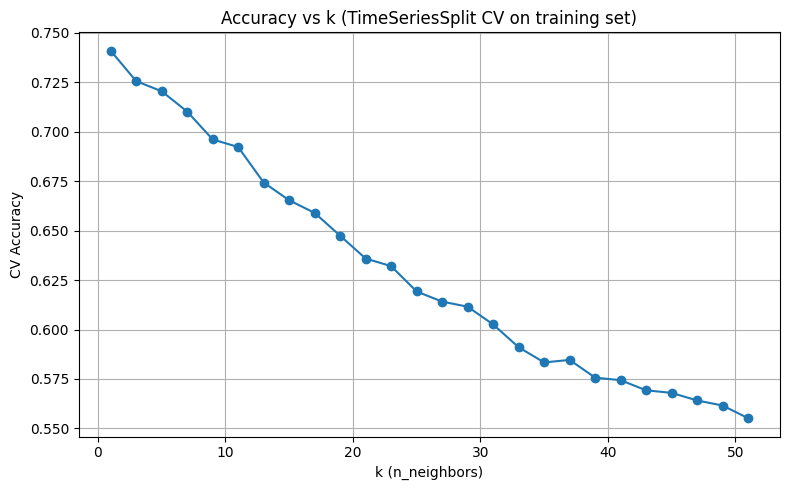

In [ ]:
results = pd.DataFrame([
    {"Method": "k-NN standard", "k": k_standard, "weights": "uniform",
     "accuracy": res_standard["accuracy"], "precision_macro": res_standard["precision_macro"],
     "recall_macro": res_standard["recall_macro"], "f1_macro": res_standard["f1_macro"],
     "train_time_s": res_standard["train_time_s"], "pred_time_s": res_standard["pred_time_s"]},
    {"Method": "k-NN optimized (TimeSeriesSplit + distance)", "k": res_opt["best_k"], "weights": "distance",
     "accuracy": res_opt["accuracy"], "precision_macro": res_opt["precision_macro"],
     "recall_macro": res_opt["recall_macro"], "f1_macro": res_opt["f1_macro"],
     "train_time_s": res_opt["train_time_s"] + res_opt.get("grid_search_time_s", 0),
     "pred_time_s": res_opt["pred_time_s"]}
])
print("\nResults summary:\n", results)
results.to_csv("knn_comparative_results_summary.csv", index=False)
print("Saved knn_comparative_results_summary.csv")

# ---------- 8) Plot Accuracy vs k (from CV)
mean_test_scores = grid.cv_results_['mean_test_score']
param_k = np.array(grid.cv_results_['param_n_neighbors'].data, dtype=int)
sort_idx = np.argsort(param_k)
plt.figure(figsize=(8,5))
plt.plot(param_k[sort_idx], mean_test_scores[sort_idx], marker='o')
plt.title('Accuracy vs k (TimeSeriesSplit CV on training set)')
plt.xlabel('k (n_neighbors)')
plt.ylabel('CV Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()

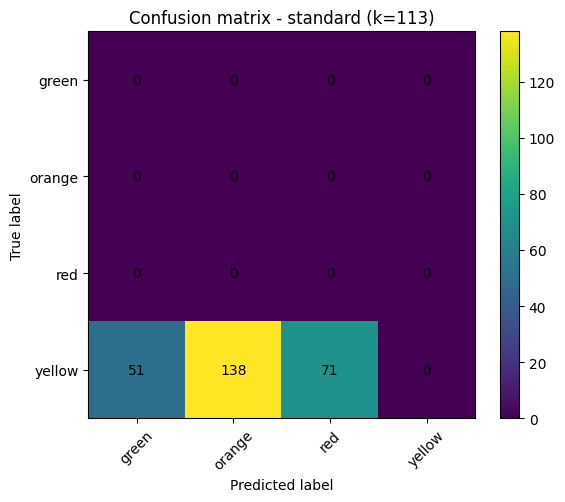

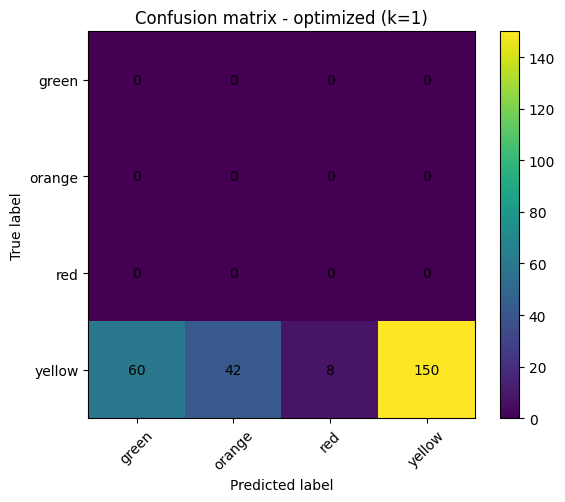

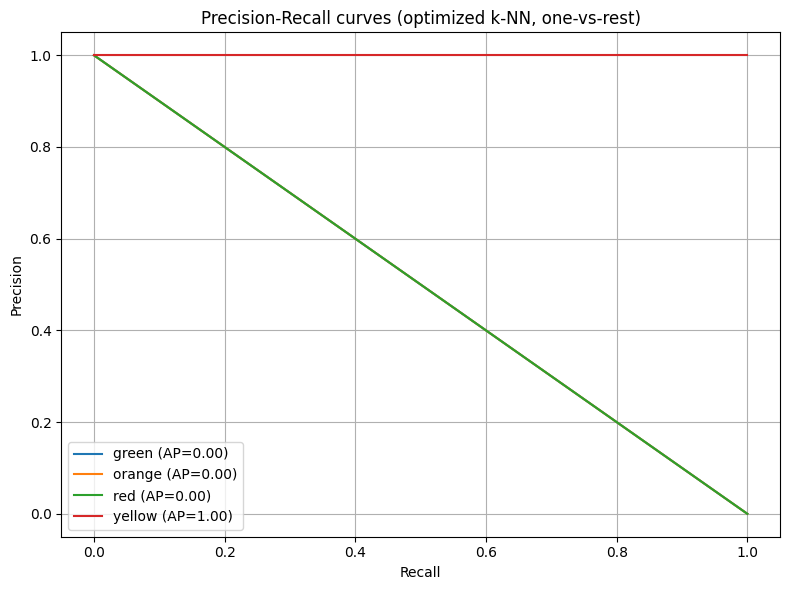


Classification report - standard:
              precision    recall  f1-score   support

       green       0.00      0.00      0.00       0.0
      orange       0.00      0.00      0.00       0.0
         red       0.00      0.00      0.00       0.0
      yellow       0.00      0.00      0.00     260.0

    accuracy                           0.00     260.0
   macro avg       0.00      0.00      0.00     260.0
weighted avg       0.00      0.00      0.00     260.0


Classification report - optimized:
              precision    recall  f1-score   support

       green       0.00      0.00      0.00         0
      orange       0.00      0.00      0.00         0
         red       0.00      0.00      0.00         0
      yellow       1.00      0.58      0.73       260

    accuracy                           0.58       260
   macro avg       0.25      0.14      0.18       260
weighted avg       1.00      0.58      0.73       260


Done. Files created: knn_comparative_results_summary.csv


In [ ]:
def plot_cm(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i,j], ha='center', va='center')
    plt.tight_layout()
    plt.show()

plot_cm(y_test, res_standard['y_pred'], classes, f"Confusion matrix - standard (k={k_standard})")
plot_cm(y_test, res_opt['y_pred'], classes, f"Confusion matrix - optimized (k={res_opt['best_k']})")

# ---------- 10) Precision-Recall curves (one-vs-rest) for optimized model
# Binarize y_test for multiclass PR curves
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))
proba_opt = best_knn.predict_proba(X_test_scaled)
plt.figure(figsize=(8,6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], proba_opt[:, i])
    ap = average_precision_score(y_test_binarized[:, i], proba_opt[:, i])
    plt.plot(recall, precision, label=f"{classes[i]} (AP={ap:.2f})")
plt.title("Precision-Recall curves (optimized k-NN, one-vs-rest)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- 11) Detailed classification reports
print("\nClassification report - standard:")
print(classification_report(y_test, res_standard['y_pred'], target_names=classes, zero_division=0))
print("\nClassification report - optimized:")
print(classification_report(y_test, res_opt['y_pred'], target_names=classes, zero_division=0))

# End
print("\nDone. Files created: knn_comparative_results_summary.csv")